# Forecasting the passenger traffic in Airplanes (Time Series) using ARIMA model 

> *Data Importing*

In [1]:
from datetime import datetime

#for numerical computations like log,exp,sqrt etc
import numpy as np

#for reading & storing data, pre-processing
import pandas as pd            

#for visualization
import matplotlib.pylab as plt 

%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


> *Data Loading*

In [2]:
dataset = pd.read_csv('AirPassengers.csv')

#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


> *Data Visualisation*: 
To observe trends, if any

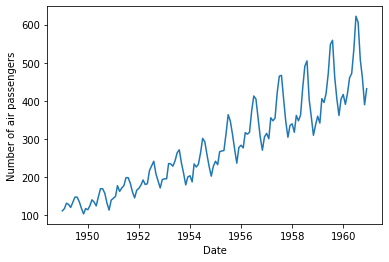

In [3]:
# plot the graph of the data given
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

From the above plot, a Trend component in the series is observed.

> *Determine rolling statistics*

# Tests to check if Series is Stationary

> *1. Plotting the Rolling statistics : A visual technique to observe whether the time series is stationary*

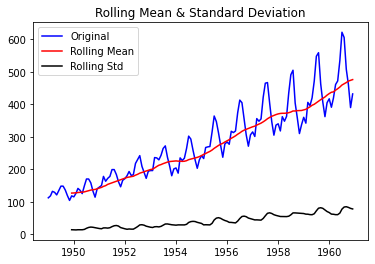

In [38]:
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()

orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In the graph, it can be sbserved that the rolling mean has a trend component even though rolling standard deviation is fairly constant with time. 

For the time series to be stationary, both the rolling statistics (ie: the mean and the standard deviation must remain time invariant or constant with time. Thus the curves for both of them must to be parallel to the x-axis.
In the graph above, this is not the case.

To further augment our hypothesis that the time series is not stationary, the ADCF test will be performed.

ADCF Test - Augmented Dickey–Fuller test is used to gives us various values that can help in identifying whether a time series is stationarity. The Null hypothesis says that a TS is non-stationary. It comprises of Test Statistics & some critical values for some confidence levels (The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics). If the Test statistics is less than the critical values, we can reject the null hypothesis and say that the series is stationary. THE ADCF test also gives us a p-value. According to the null hypothesis, lower values of p corresponds to a better model.

> *2. Perform Augmented Dickey–Fuller test*

In [6]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


From the results of the above ADCF test performed, the p-value(whose highest value can be 1.0) is very large(here, 0.8). Furthermore, the critical values are far from being close to the Test Statistics. Hence, we can conclude that the Time Series is not stationary at this point.

> *Defining a function to check whether series is stationary or not using Rolling Statistics and ADCF Test*

In [10]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Data Transformation to achieve Stationarity 

> *1. Log Scale Transformation* 


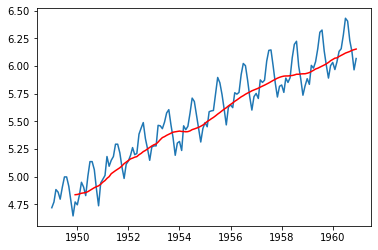

In [39]:
#The below transformation is required to make series stationary
indexedDataset_logScale = np.log(indexedDataset)
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In the above graph, even though rolling mean is not stationary, it is still better than the original case having no transformations applied to the series. 

As can be observed from the graph above, the Time series in log scale as well as its moving average have a trend component. Thus, we can apply an elementary calculation.

logscale L=stationarypart(L1)+trend(LT) 
movingavgoflogscale A=stationarypart(A1)+trend(AT) 
resultseries R=L−A=(L1+LT)−(A1+AT)=(L1−A1)+(LT−AT) 
Since, L & A are series & it moving avg, their trend will be more or less same, Hence
LT-AT nearly equals to 0

Thus trend component will be almost removed. 
And the final non-trend curve
R=L1−A1 
will b obtained.

In [9]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


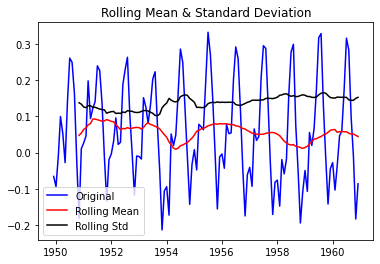

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
test_stationarity(datasetLogScaleMinusMovingAverage)

From the above test, it can be observed that after the Log Scale Transformation, the p-value has reduced from 0.99 to 0.022.

The critical values at 1%,5%,10% confidence intervals are much closer to the Test Statistic. 

Thus, we can conclude that our given series is stationary.

> *2. Exponential Decay Transformation*

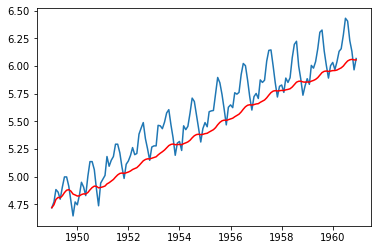

In [11]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

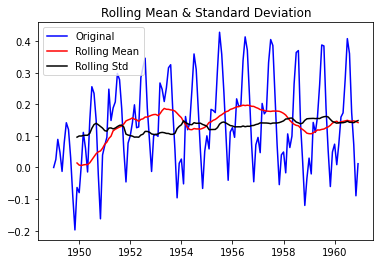

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

In the abover, it can be observed that the Time Series is stationary
The series for moving avgerage & standard deviation is almost parallel to x-axis thus they also have no trend.
P-value has decreased from 0.022 to 0.005.
Test Statistic value is very much closer to the Critical values.

The above suggest that the exponential decay transformation is better than the previous logarithmic transformation. 

> *3. Time Shift Transformation*

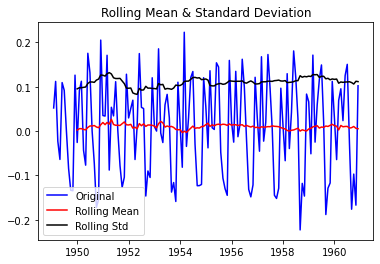

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [13]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From the graphs above, visually this appears to be the best result as our series along with rolling statistic values of moving average & moving standard deviation seems more flat and stationary in comparison to the others. 

However, the ADCF test shows us that:
p-value of 0.07 is not as good as 0.005 of exponential decay.
Test Statistic value not as close to the critical values as that for exponential decay.

However, we will proceed with the log scale as it will be easier to revert back to the original scale during forecasting.


The components of the series need to be separated. After which, the trend & seasonality will be ignored and the nature of the residual part will be checked.

# Decomposition of the Time Series into Trend, Seasonal and Residual

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


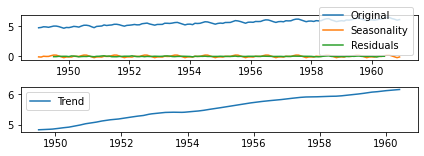

In [15]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()



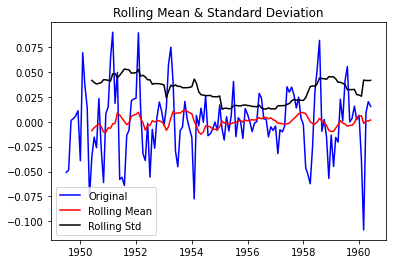

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [16]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

> *Plotting Correlation Function and Partial Correlation Function*

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


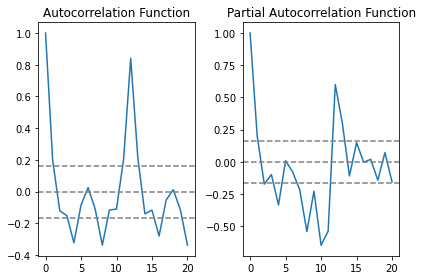

In [17]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=2. 
Thus, from theory, Q = 2 

From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

# Building Models

The models will give a value of RSS. Lower RSS values indicate a better model.

> *1. AR Model*

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


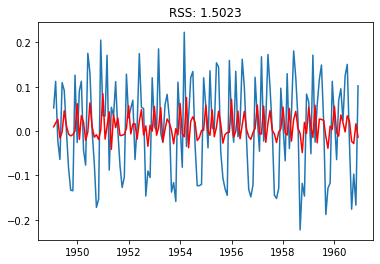

In [18]:
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

AR Model;
Order=(2,1,0);
RSS=1.5023


> *2. MA Model*

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA model


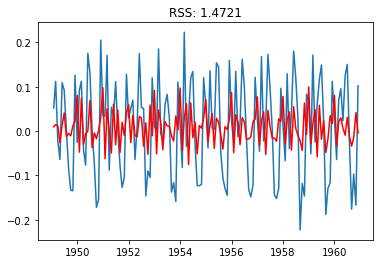

In [19]:
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')

MA Model; order=(0,1,2); RSS: 1.4721 

> *ARIMA Model*

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


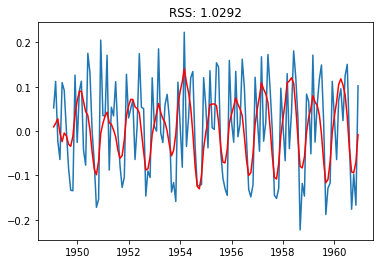

In [20]:
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

ARIMA Model; Order=(2,1,2); RSS: 1.0292

Amonst AR, MA and ARIMA, it is observed that the RSS value is the least (equal to 1.0292) in case of ARIMA model, indicating it to be the best among the three.

With the ARIMA model built, predictions will be generated in this project. But, before that we need to reconvert the predictions back to original form as the model was built on log transformed data.

# Prediction & Reverse transformations

In [21]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [22]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372554
1960-09-01    1.280204
1960-10-01    1.186191
1960-11-01    1.116267
1960-12-01    1.108140
Length: 143, dtype: float64


In [23]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

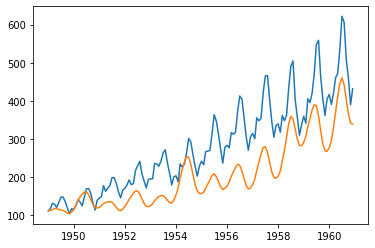

In [24]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [25]:
indexedDataset_logScale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


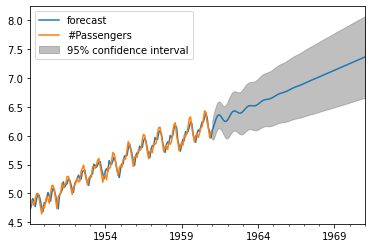

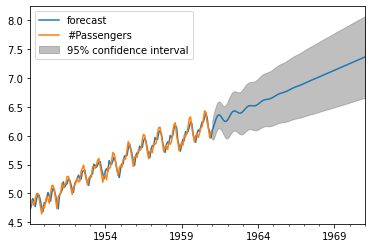

In [33]:
results_ARIMA.plot_predict(1,264) 

In [35]:
x=results_ARIMA.forecast(steps=120)


In [36]:
print(x[1])
print(len(x[1]))
print(np.exp(x[1]))

[0.08384711 0.10749461 0.11568692 0.11702772 0.11703494 0.11744015
 0.11762247 0.11778711 0.1202416  0.12736039 0.13870955 0.15118786
 0.16157805 0.16834385 0.17177318 0.17311971 0.17358721 0.17385448
 0.17430206 0.1754332  0.17788136 0.18195711 0.18726205 0.1928338
 0.1976923  0.20130624 0.20369039 0.20519816 0.20625253 0.20720983
 0.20836955 0.21000311 0.21229728 0.21524462 0.21860163 0.22198239
 0.22503046 0.22755276 0.22954788 0.23114779 0.23253806 0.23390515
 0.23541291 0.23718293 0.23926519 0.24161518 0.24410351 0.24656337
 0.24885235 0.25089608 0.25269712 0.25431606 0.2558429  0.25737206
 0.25898368 0.26072828 0.26261526 0.26461067 0.26664876 0.26865458
 0.27056825 0.27236073 0.27403677 0.2756275  0.27717805 0.27873502
 0.28033567 0.28199994 0.28372658 0.28549485 0.28727185 0.2890232
 0.29072311 0.29236057 0.29394015 0.2954785  0.29699843 0.2985225
 0.30006754 0.30164101 0.30323987 0.30485241 0.30646228 0.30805357
 0.30961513 0.3111431  0.31264096 0.31411768 0.31558476 0.3170529